# Comparison with analytic beam solution


C:\Users\knutankv\Jottacloud\postdoc-ntnu\projects\dynamic-instability\analyses\beef-development\code\corot\nlfe2d.py:554: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif mass_formulation is 'timoshenko':
C:\Users\knutankv\Jottacloud\postdoc-ntnu\projects\dynamic-instability\analyses\beef-development\code\corot\nlfe2d.py:556: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif mass_formulation is 'euler':
C:\Users\knutankv\Jottacloud\postdoc-ntnu\projects\dynamic-instability\analyses\beef-development\code\corot\nlfe2d.py:558: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif mass_formulation  is 'euler_trans':
C:\Users\knutankv\Jottacloud\postdoc-ntnu\projects\dynamic-instability\analyses\beef-development\code\corot\nlfe2d.py:560: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif mass_formulation is 'lumped':
C:\Users\knutankv\Jottacloud\postdoc-ntnu\projects\dynamic-instability\analyses\beef-development\code\corot\nlfe2d.py:834: SyntaxWa

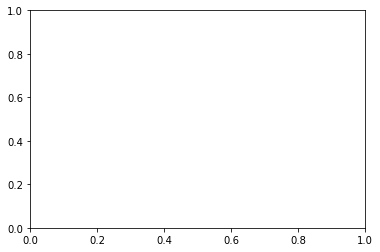

In [1]:
from sys import path
path.append('C:/Users/knutankv/git-repos/paajthon/')     # paajthon path

import numpy as np
import nlfe2d as nlfe
import beef
from beef.newmark import factors as newmark_factors, stable_increment, factors_from_alpha
import matplotlib.pyplot as plt


In [2]:
from beef import newmark

In [3]:
#%% Define system
n_els = 10
node_labels = np.arange(1, n_els+2)

E = 210e9
A = 10000
I = 0.1
m = 100000
print(m/A)
properties = nlfe.SectionProperties(E, A, I, m=m)
print(properties.G)

# True part
L = 100
x = np.linspace(0, L, n_els+1)
y = x*0
node_matrix = np.vstack([node_labels, x, y]).T
element_matrix = beef.nodes_to_beam_element_matrix(node_labels)
constraints = [nlfe.Constraint([node_labels[0], node_labels[-1]], dofs=['trans', 'trans'])]

part = nlfe.Part(node_matrix, element_matrix, properties, constraints, force_psi=0.7, shear_flexible=False, mass_formulation='euler')

10.0
80769230769.23077


[ 0.0718575   0.28599212  0.63856458  1.12458389  1.73946196  2.4801745
  3.34485759  4.32705609  5.37940241  7.98951473  8.87004821 10.50977108
 12.49082399 14.79543547 17.45130295 20.46893433 23.76728912 27.04057362
 29.62254484 30.63226211]
[ 0.07198293  0.28793172  0.64784638  1.15172689  1.79957327  2.5913855
  3.5271636   4.60690756  5.83061739  7.19829307  8.70993461 10.36554202
 12.16511529 14.10865442 16.19615941 18.42763026 20.80306697 23.32246954
 25.98583798 28.79317228]


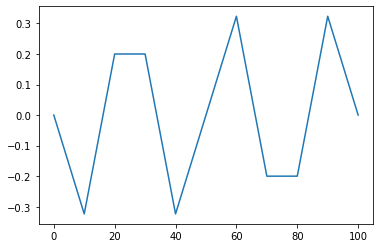

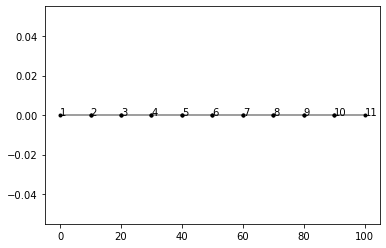

In [4]:
#%% Natural frequencies
from knutils.modal import statespace 

M = part.L.T @ part.m @ part.L
K = part.L.T @ part.k @ part.L
n_dofs = M.shape[0]
lambd, phi0 = np.linalg.eig(np.linalg.inv(M) @ K)

om_n, ix = np.unique(np.sqrt(lambd), return_index=True)

phi0 = phi0[:n_dofs, ix]

phi = np.real(np.vstack([part.L @ phi0[:, ix] for ix in range(0, len(om_n))]).T)
plt.plot(x, phi[1::3,13])
print(om_n[0:20]/2/np.pi)
fig = plt.figure()
part.plot(plot_nodes=True, node_labels=True)

exact = np.array([n**2*np.pi**2 for n in range(1,21)]) * np.sqrt(E*I/(m*L**4))

print(exact/2/np.pi)


Exact vs FE u_max: 9.92063492063492e-05m vs. 9.960815465991056e-05m
Exact vs FE end angle: -2.9761904761904763e-06rad vs. -2.975462864013375e-06rad


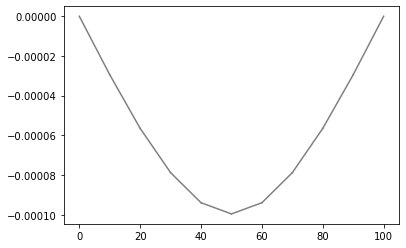

In [5]:
force_amplitude = -100
forces = [nlfe.Force(force_amplitude, [6], 1)]
analysis = nlfe.Analysis(part, forces)

analysis.run_static()
analysis.part.plot()

exact = -force_amplitude*L**3/(48*E*I)

print(f'Exact vs FE u_max: {exact}m vs. {np.max(-analysis.u[1::3,1])}m')
print(f'Exact vs FE end angle: {force_amplitude*L**2/(16*E*I)}rad vs. {analysis.u[2,1]}rad')


In [6]:
# Force definiton
tmax = 10
w = 2
t = np.arange(0, tmax+2*np.pi/w/20, 2*np.pi/w/20)
force_amplitude = np.sin(w*t)
forces = [nlfe.Force(force_amplitude, [6], 1, t=t)]

# Simulation
dt = 0.1
alpha = -0.1

In [7]:
# Non-linear HHT
analysis_hht = nlfe.Analysis(part, forces, dt=dt, tmax=tmax, newmark_factors=factors_from_alpha(alpha))
u_hht = analysis_hht.run_dynamic(return_results=True)

In [8]:
analysis_lin_hht = nlfe.Analysis(part, forces, dt=dt, tmax=tmax, newmark_factors=factors_from_alpha(alpha))
u_lin_hht = analysis_lin_hht.run_lin_dynamic(return_results=True, solver='full_hht')
u_lin_hht_quasi = analysis_lin_hht.run_lin_dynamic(return_results=True)

In [9]:
analysis_constant = nlfe.Analysis(part, forces, dt=dt, tmax=tmax, newmark_factors=newmark_factors('constant'))
u_lin_constant = analysis_constant.run_lin_dynamic(return_results=True)

In [10]:
dt_stable = stable_increment(max(om_n))
print(f'dt_stable = {dt_stable} s')

analysis_linear = nlfe.Analysis(part, forces, dt=dt_stable, tmax=tmax, newmark_factors=newmark_factors('linear'))
u_lin_linear = analysis_linear.run_lin_dynamic(return_results=True)

dt_stable = 7.15560683530504e-05 s


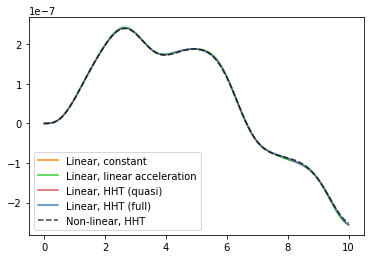

In [11]:
plt.plot(analysis_constant.t, u_lin_constant[nlfe.gdof_from_nodedof(5-1, 1, n_dofs=3),:].T, color='DarkOrange', label='Linear, constant')
plt.plot(analysis_linear.t, u_lin_linear[nlfe.gdof_from_nodedof(5-1, 1, n_dofs=3),:].T, color='LimeGreen', label='Linear, linear acceleration')
plt.plot(analysis_lin_hht.t, u_lin_hht_quasi[nlfe.gdof_from_nodedof(5-1, 1, n_dofs=3),:].T, color='IndianRed', label='Linear, HHT (quasi)')
plt.plot(analysis_lin_hht.t, u_lin_hht[nlfe.gdof_from_nodedof(5-1, 1, n_dofs=3),:].T, color='SteelBlue', label='Linear, HHT (full)')
plt.plot(analysis_hht.t, u_hht[nlfe.gdof_from_nodedof(5-1, 1, n_dofs=3),:].T, color='Black', label='Non-linear, HHT', linestyle='--', alpha=0.75)

plt.legend()